# Amazon SageMaker Debugger XGBoost training report for Higgs Boson Detection Challenge
This tutorial walks thorugh an example of training an XGBoost model using data from the [2014 ATLAS Higgs Boson Machine Learning Challenge](http://opendata.cern.ch/record/328). This example showcases some of the new features available in SageMaker Debugger, such as the deep profiling and the XGBoost training report.

The [Debugger profiling report](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html) displays hardware resource utilization metrics such as cpu, gpu, memory, and IO utilization. Debugger will help you identify any hardware bottlenecks and appropriately choose the right-sized instance for your training job.

The [Debugger XGBoost training report](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-training-xgboost-report.html) will provide a comprehensive evaluation of your model's performance to help you fine-tune and improve your model.

The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) makes it easy to train XGBoost models accessing other AWS services, such as Amazon EC2, Amazon ECR, and Amazon S3. For more information about the XGBoost model and SageMaker, see the [XGBoost Algoritm Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) and the [SageMaker Python SDK documentation](https://github.com/aws/sagemaker-python-sdk).

### Table of contents
* [Setup and imports](#setup)
* [Get and prepare data](#data)
* [Create the SageMaker XGBoost Estimator](#estimator)
* [Train XGBoost Model](#train)
* [View post training reports](#reports)

## Setup<a class="anchor" id="setup"></a>
This notebook was created and tested on an `ml.t3.medium` notebook instance.

After we've installed and imported the required packages, we'll need to specify a few variable that will be utilized throughout the example notebook:
- `role`: The IAM role to run SageMaker training jobs. The default SageMaker role with the SageMaker full access policy will be used.
- `sess`: The SageMaker session that interacts with different AWS services.
- `bucket`: The S3 bucket where the model's input and output data will be stored. We will use the default S3 bucket automatically paired with the SageMaker session.
- `key_prefix`: The directory in the S3 bucket where we'll store the input and output data.
- `region`: The AWS region where we operate the SageMaker training job.
- `s3`: the s3fs client to make it easier to read and write data from and to the S3 bucket.
- `xgboost_container`: The URI for the XGBoost training container for our region.

In [ ]:
#!pip install -Uqq sagemaker
!pip install -Uqq s3fs==0.4.2

In [ ]:
import requests
from io import BytesIO
import pandas as pd
import s3fs
from datetime import datetime
import time
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule, rule_configs

from IPython.display import FileLink, FileLinks

In [ ]:
# setup sagemaker variables
role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
bucket = sess.default_bucket()
key_prefix = "higgs-boson"
region = sess._region_name
s3 = s3fs.S3FileSystem(anon=False)

xgboost_container = image_uris.retrieve("xgboost", region, "1.2-1")

## Get and prepare data <a class="anchor" id="data"></a>

The data for this example notebook is provided by the European Organization for Nuclear Research (CERN). This data was utilized in a 2014 machine learning competition where participants had to develop an algorithm that improves the detection of Higgs boson signal events decaying into two tau particles from a sample of simulated ATLAS data. More background and details on this interesting data set can be found at Dataset from the [ATLAS Higgs Boson Machine Learning Challenge 2014](http://opendata.cern.ch/record/328)

In [ ]:
# Download the data from CERN and load it directly into memory
data_url = "http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz"
gz_file = BytesIO(requests.get(data_url).content)
gz_file.flush()
df = pd.read_csv(gz_file, compression="gzip")

In [ ]:
# We remove the columns we don't need and identify columns that will be used as features as well as the target
non_feature_cols = ["EventId", "Weight", "KaggleSet", "KaggleWeight", "Label"]
feature_cols = [col for col in df.columns if col not in non_feature_cols]
label_col = "Label"
df["Label"] = df["Label"].apply(lambda x: 1 if x == "s" else 0)

# The original competition split the data out into training and validation sets. The data includes a column that identifies which sample falls into which set
train_data = df.loc[df["KaggleSet"] == "t", [label_col, *feature_cols]]
test_data = df.loc[df["KaggleSet"] == "b", [label_col, *feature_cols]]

In [ ]:
# using the SageMaker session, we upload the data to S3
for name, dataset in zip(["train", "test"], [train_data, test_data]):
    sess.upload_string_as_file_body(
        body=dataset.to_csv(index=False, header=False),
        bucket=bucket,
        key=f"{key_prefix}/input/{name}.csv",
    )

In [ ]:
# configure data inputs for SageMaker training
train_input = TrainingInput(f"s3://{bucket}/{key_prefix}/input/train.csv", content_type="text/csv")
validation_input = TrainingInput(
    f"s3://{bucket}/{key_prefix}/input/test.csv", content_type="text/csv"
)

## Create XGBoost Estimator <a class="anchor" id="estimator"></a>

Here we create a SageMaker Estimator using the XGBoost image prepared by SageMaker. We attach the SageMaker Debugger built-in `create_xgboost_report()` rule to automatically generate an XGBoost training report after the training job is complete. SageMaker Debugger also turns on the [ProfilerReport](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html) rule and autogenerate a report regarding system resource utilization and bottleneck detection results

In [ ]:
# hyperparameters for the XGBoost model
hyperparameters = {"objective": "binary:logistic", "num_round": "100", "eval_metric": "error"}

# add a rule to generate the XGBoost Report
rules = [Rule.sagemaker(rule_configs.create_xgboost_report())]

In [ ]:
# Create SageMaker Estimator using the XGBoost image
estimator = Estimator(
    role=role,
    image_uri=xgboost_container,
    base_job_name="higgs-boson-model",
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=hyperparameters,
    rules=rules,
)

## Train XGBoost Model <a class="anchor" id="train"></a>
Finally we launch a training job to train the XGBoost model

In [ ]:
estimator.fit({"train": train_input, "validation": validation_input}, wait=True)

## Download SageMaker Debugger Reports <a class="anchor" id="reports"></a>
SageMaker Debugger generates profiling and training reports through a pair of processing jobs that run concurrent to the training job. The code below will download the outputs from the Debugger report output S3 URI to your current Jupyter working directory for easier viewing. 

In [ ]:
import os

# get name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

# get name of the xgboost training report
xgb_profile_job_name = [
    rule["RuleEvaluationJobArn"].split("/")[-1]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "CreateXgboostReport" in rule["RuleConfigurationName"]
][0]

base_output_path = os.path.dirname(estimator.latest_job_debugger_artifacts_path())
rule_output_path = os.path.join(base_output_path, "rule-output/")
xgb_report_path = os.path.join(rule_output_path, "CreateXgboostReport")
profile_report_path = os.path.join(rule_output_path, profiler_report_name)

In [ ]:
while True:

    xgb_job_info = sess.sagemaker_client.describe_processing_job(
        ProcessingJobName=xgb_profile_job_name
    )

    if xgb_job_info["ProcessingJobStatus"] == "Completed":
        break
    else:
        print(f"Job Status: {xgb_job_info['ProcessingJobStatus']}")
        time.sleep(30)

s3.download(xgb_report_path, "reports/xgb/", recursive=True)
s3.download(profile_report_path, "reports/profiler/", recursive=True)
display(
    "Click link below to view the profiler report whcih will help you identify hardware bottlenecks.",
    FileLink("reports/profiler/profiler-output/profiler-report.html"),
)
display(
    "Click link below to view the XGBoost Training reports which will help you imporve your model",
    FileLink("reports/xgb/xgboost_report.html"),
)

### Display the Debugger Profiling report

The following code opens the downloaded profiling report. For this training job, there is no bottleneck issues found as described in the report.

In [ ]:
import IPython

IPython.display.HTML(filename="reports/profiler/profiler-output/profiler-report.html")

### Display the Debugger XGBoost training report

The following code displays the XGBoost training report. This shows how the training job made progress, such as loss values over time and statistics at `plot_step`.


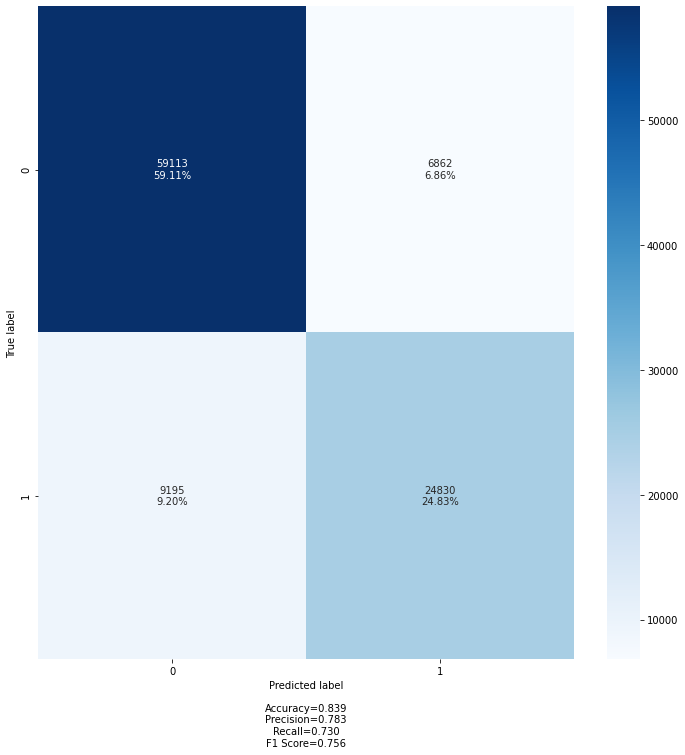

In [22]:
import IPython

IPython.display.HTML(filename="reports/xgb/xgboost_report.html")